# Implementation of Research Paper named Performance-Effective and Low-Complexity Task Scheduling for heterogenous Computing. 

* Team Member 1 : Anurag Jaiswal (2021CSM1002)
* Team Member 2 : Arunava Chaudhuri (2021CSM1020)

Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from operator import itemgetter
from queue import PriorityQueue

class DualPriorityQueue(PriorityQueue):
    def __init__(self, maxPQ=False):
        PriorityQueue.__init__(self)
        self.reverse = -1 if maxPQ else 1

    def put(self, priority, data):
        PriorityQueue.put(self, (self.reverse * priority, data))

    def get(self, *args, **kwargs):
        priority, data = PriorityQueue.get(self, *args, **kwargs)
        return self.reverse * priority, data

class Processor:
    def __init__(self,computation_cost=0,est=0,eft=0):
        self.computation_cost = computation_cost
        self.eft = eft
        self.est = est


class Task:
    def __init__(self,id,avg_compt=0.0,rank=0.0,processor_exec=0,st=0,ft=0,cpu_s=[],parents=[]):
        self.avg_compt = avg_compt # avg. computation cost across all cpu_s
        self.rank = rank
        self.processor_exec = processor_exec # the processor on which the job was finally scheduled
        self.st = st # start time in final schedule
        self.ft = ft # finish time in final schedule
        self.cpu_s = cpu_s
        self.parents = parents
        self.id = id
        self.is_exit=False
        self.is_ready=False
    def __lt__(self, other):
        return self.rank > other.rank

tasks = []
heft_tasks = []
cpop_tasks = []
num_tasks = 0
num_cpu_s = 0
MAX_TIME = 10000

dag_edge_cost = list(list())






In [ ]:
def print_tasks():
    for i in range(len(tasks)):
        print('avg_compt = ',tasks[i].avg_compt, " rank = ", tasks[i].rank, " processor_exec = ", tasks[i].processor_exec, " st = ", tasks[i].st , " ft = ", tasks[i].ft, " parents = ", tasks[i].parents )
    
def print_dag_edge_cost():
    for i in range(len(dag_edge_cost)):
            print(dag_edge_cost[i])

In [ ]:
def initialize_data(): 
    file = open('/content/drive/MyDrive/input1.txt', 'r')
    lines = file.readlines()
    lines = [ line.strip('\n') for line in lines]
    global num_tasks
    global num_cpu_s
    num_tasks = int(lines[0])
    num_cpu_s = int(lines[1])
    for i in range(num_tasks):
        tasks.append(Task(i,0,0,0,0,0,[],[]))
        if i==num_tasks-1:
            tasks[i].is_exit=True
        for j in range(num_cpu_s):
            tasks[i].cpu_s.append(Processor(0,0,0))
    for i in range(num_cpu_s):
        inp = list(lines[i+2].split(" "))
        for j in range(num_tasks):
            tasks[j].cpu_s[i].computation_cost = int(inp[j])
    global dag_edge_cost
    for i in range(num_tasks):
        v = [0]*num_tasks
        dag_edge_cost.append(v)
        inp = list(lines[num_cpu_s+2+i].split(" "))
        for j in range(num_tasks):
            dag_edge_cost[i][j] = int(inp[j])
            if dag_edge_cost[i][j] > 0:
                tasks[j].parents.append(i)



In [ ]:

# compute average or mean computation costs of all tasks
def avg_computation_calculate():
    for i in range(num_tasks):
        tasks[i].avg_compt = 0
        for j in range(num_cpu_s):
            tasks[i].avg_compt = tasks[i].avg_compt + tasks[i].cpu_s[j].computation_cost
        tasks[i].avg_compt = tasks[i].avg_compt / num_cpu_s


In [ ]:
#  for every node, recursively find the upper rank
def upward_rank_calculate(node):
    sub_rank = 0; #  rank of the dependent task
    temp_max = 0; #  temp_max = maximum of(cost of communication between tasks + rank(i))

    for i in range(num_tasks): #  for every node
        if (dag_edge_cost[node][i] > 0): #  that has an incoming edge from main node
            sub_rank = upward_rank_calculate(i) #  calculate its upper rank
            if (sub_rank + dag_edge_cost[node][i] > temp_max): #  if the upper rank is max among others
                temp_max = sub_rank + dag_edge_cost[node][i]; #  set this as the max
            
    
    return temp_max + tasks[node].avg_compt; #  rank of the main node

In [ ]:
def downward_rank_calculate(node):
    sub_rank = 0; #  rank of the dependent task
    temp_max = 0; #  temp_max = maximum of(cost of communication between tasks + rank(i))

    for i in range(num_tasks): #  for every node
        if (dag_edge_cost[i][node] > 0): #  that has an incoming edge from main node
            sub_rank = downward_rank_calculate(i) #  calculate its upper rank
            if (sub_rank + dag_edge_cost[i][node] + tasks[i].avg_compt> temp_max): #  if the upper rank is max among others
                temp_max = sub_rank + dag_edge_cost[i][node]+ tasks[i].avg_compt; #  set this as the max
            
    
    return temp_max  #  rank of the main node

In [ ]:

def get_my_key(obj):
    return obj['size']
 
def compare(x, y):
    return tasks[x].rank > tasks[y].rank


#  sort the tasks w.r.t upper ranks and return in a vector
def sortRank(tasks):
    temp=[]
    for i in range(num_tasks):
        p=[round(tasks[i].rank),tasks[i].id]
        temp.append(p)
    sort_job=sorted(temp,key=itemgetter(0),reverse=True)
    in_sort=[p[1] for p in sort_job]

    return in_sort

In [ ]:
# Funnction for creating critical path
def create_critical_path(tasks):
    critical_path=[]
    temp=tasks[0]
    entry_priority=round(tasks[0].rank)
    i=0
    p=0
    critical_path.append(temp)
    #print("first job id: ",critical_path[p].id+1)
    p=p+1
    #print("In critical path: ",critical_path[p].id)
    while(temp.is_exit!=1):
        #print("In critical path")
        for j in range(num_tasks):
            if(dag_edge_cost[i][j]>0 and round(tasks[j].rank)==entry_priority):
                i=j
                temp=tasks[j]
                critical_path.append(tasks[j])
                #print("In critical path: ",critical_path[p].id+1)
                p=p+1
                break
    return critical_path

In [ ]:
#Function for finding critical processor
def crictical_processor(critical_path):
    mincost=[]
    for i in range(num_cpu_s):
        cric_cost=0
        for j in range(len(critical_path)):
            cric_cost+=critical_path[j].cpu_s[i].computation_cost
        mincost.append(cric_cost)
# =============================================================================
#     print("mincost = ",end=" ")
#     for i in range(len(mincost)):
#         print(mincost[i] ,end= " ")
#     print('\n')
# =============================================================================
    return mincost.index(min(mincost))

In [ ]:
#  searches for gaps in between tasks on a processor and returns where the insertion should be
def jobInsertion(search_end,processor_state,job_index,processor_index,search_start):
    t = tasks[job_index].cpu_s[processor_index].computation_cost;
    counter = 0
    for i in range(search_start,search_end):
        if (processor_state[processor_index][i] == False):
            counter+=1
        else:
            counter = 0
        if (counter == t): #  as soon as a compatible gap is found, return its location
            return i
    return max(search_end, search_start); #  if no gaps were found, resume the scheduling as normal



In [ ]:
#  calculate earliest start and finish times of all tasks
def schedule(rank_index_sorted):

    '''  free_processor denotes the time at which the processor will be free after its latest job '''
    free_processor = [0]*num_cpu_s 
    ''' same as job[index_i].processor_exec ''' 
    current_processor = -1 
    '''  delay added to free_processor, accounting for finish times of all parent nodes and communication costs '''
    delay_job_parent = [0]*num_tasks
    processor_state = [[False]* MAX_TIME ]*num_cpu_s
    for i in range(num_tasks):
        index_i = rank_index_sorted[i]; 
        
        ready_processor = [[] for i in range(num_cpu_s)]
        ''' iterating for each processor for each job '''
        for j in range(num_cpu_s):
            ''' iterating for each parent node of the job estimate ready times '''
            for k in range(len(tasks[index_i].parents)): 
                ''' on same processor, ignore communication cost ''' 
                if (tasks[tasks[index_i].parents[k]].processor_exec == j):  
                    
                    ready_processor[j].append(tasks[tasks[index_i].parents[k]].ft)

                     
                else: 
                    ready_processor[j].append(dag_edge_cost[tasks[index_i].parents[k]][index_i] + tasks[tasks[index_i].parents[k]].ft) # on processor different from the processor parent was executed on, add communication cost delay
            if (len(ready_processor[j]) <= 0): # final delay on the processor for each job, this considers everythin
                delay_job_parent[j] = 0
            else:
                delay_job_parent[j] = max(ready_processor[j])
                
            tasks[index_i].cpu_s[j].est = jobInsertion(free_processor[j], processor_state, index_i, j, delay_job_parent[j])
            tasks[index_i].cpu_s[j].eft = tasks[index_i].cpu_s[j].est + tasks[index_i].cpu_s[j].computation_cost
        current_processor = min(range(len(tasks[index_i].cpu_s)), key=lambda i: tasks[index_i].cpu_s[i].eft)
        tasks[index_i].ft = tasks[index_i].cpu_s[current_processor].eft
        tasks[index_i].st = tasks[index_i].cpu_s[current_processor].est
        free_processor[current_processor] = tasks[index_i].ft
        tasks[index_i].processor_exec = current_processor
        
        ''' updating the state of processor to reflect that processor was in use for the entire duration of job execution '''
        for j in range(tasks[index_i].st,tasks[index_i].ft): 
            processor_state[current_processor][j] = True

def showpq(gq):
    g = gq;
    i=0
    while (len(g)!=i):
        k=g[i].id+1; 
        print(k,end=" ")
        i=i+1
    print('\n')

In [ ]:

# Function for scheduling using CPOP algorithm
def schedule_cpop(critical_path, critical_processor):
    order=[]
    free_processor = [0]*num_cpu_s 
    current_processor = -1
    delay_job_parent = [0]*num_tasks 
    processor_state = [[False]* MAX_TIME ]*num_cpu_s
    schedule_queue=[]
    schedule_queue.append(critical_path[0])
    roundk=1
    while(len(schedule_queue)>0):
        #print(len(schedule_queue))
        #showpq(schedule_queue)
        #print("round: \n",roundk)
        index_i = schedule_queue[0].id; # for making the code simpler
        tasks[index_i].is_ready=True
        order.append(index_i+1)
        #print("in cpop schedule: ",index_i+1,"***********************************")
        ready_processor=[[] for i in range(num_cpu_s)]
        check=False
        for j in range(len(critical_path)):
            if(index_i==critical_path[j].id):
                check=True
                break
        if(check==1):
            #print("critical processor: ",critical_processor," critical task: ",index_i+1)
            ''' iterating for each parent node of the job calculate ready times '''
            for k in range(len(tasks[index_i].parents)):
                ''' #  on same processor, ignore communication cost '''
                if (tasks[tasks[index_i].parents[k]].processor_exec == critical_processor):  
                    ready_processor[critical_processor].append(tasks[tasks[index_i].parents[k]].ft)
                else: 
                    ready_processor[critical_processor].append(dag_edge_cost[tasks[index_i].parents[k]][index_i] + tasks[tasks[index_i].parents[k]].ft) # if processor different from the processor parent was executed on, add communication cost delay
            if (len(ready_processor[critical_processor]) <= 0): 
                delay_job_parent[critical_processor] = 0
            else: # final delay on the processor for each job, this considers everything
                delay_job_parent[critical_processor] = max(ready_processor[critical_processor])
            tasks[index_i].cpu_s[critical_processor].est = jobInsertion(free_processor[critical_processor], processor_state, index_i, critical_processor, delay_job_parent[critical_processor])
            tasks[index_i].cpu_s[critical_processor].eft = tasks[index_i].cpu_s[critical_processor].est + tasks[index_i].cpu_s[critical_processor].computation_cost
            current_processor = critical_processor

            tasks[index_i].st = tasks[index_i].cpu_s[current_processor].est
            tasks[index_i].ft = tasks[index_i].cpu_s[current_processor].eft
            tasks[index_i].processor_exec = current_processor
            free_processor[current_processor] = tasks[index_i].ft
           
            
            ''' updating the state of processor to reflect that processor was in use for the entire duration of job execution '''
            for j in range(tasks[index_i].st,tasks[index_i].ft): 
                processor_state[current_processor][j] = True
        else:
            #print("in non critical path schedule: ",index_i)
            '''  iterate over for each processor with respect to each job '''
            for j in range(num_cpu_s): 
                ''' #  for each parent node of the job evaluate ready times '''
                for k in range(len(tasks[index_i].parents)): 
                    ''' on same processor, ignore communication cost '''
                    if (tasks[tasks[index_i].parents[k]].processor_exec == j):  
                        ready_processor[j].append(tasks[tasks[index_i].parents[k]].ft)
                    else:  # on different processor from the processor parent was executed on, add communication cost delay
                       ready_processor[j].append(dag_edge_cost[tasks[index_i].parents[k]][index_i] + tasks[tasks[index_i].parents[k]].ft)
                if (len(ready_processor[j]) <= 0): 
                    delay_job_parent[j] = 0
                else: # final delay on the processor for each job, this considers everything
                    delay_job_parent[j] = max(ready_processor[j])
                    
                tasks[index_i].cpu_s[j].est = jobInsertion(free_processor[j], processor_state, index_i, j, delay_job_parent[j])
                tasks[index_i].cpu_s[j].eft = tasks[index_i].cpu_s[j].est + tasks[index_i].cpu_s[j].computation_cost
            current_processor = min(range(len(tasks[index_i].cpu_s)), key=lambda i: tasks[index_i].cpu_s[i].eft)
            tasks[index_i].ft = tasks[index_i].cpu_s[current_processor].eft
            tasks[index_i].st = tasks[index_i].cpu_s[current_processor].est
            free_processor[current_processor] = tasks[index_i].ft
            tasks[index_i].processor_exec = current_processor
            
            ''' #  updating the state of processor to reflect that processor was in use for the entire duration of job execution '''
    
            for j in range(tasks[index_i].st,tasks[index_i].ft): 
                processor_state[current_processor][j] = True
        schedule_queue.pop(0)
        
        #showpq(schedule_queue);
        for bv in range(num_tasks):
            if(dag_edge_cost[index_i][bv]>0):
                flag=0
                for k in range(len(tasks[bv].parents)):
                    if(tasks[tasks[bv].parents[k]].is_ready!=True):
                        flag=1
                        break
                if(flag==0):
                    schedule_queue.append(tasks[bv])
        
        schedule_queue=sorted(schedule_queue,key=lambda x: x.rank,reverse=True)
        #print("After sorting:\n")
        #showpq(schedule_queue);
        #print(len(schedule_queue))
        roundk=roundk+1
    return order






In [ ]:
# heft_tasks = []

import copy
# copy_list = copy.deepcopy()

In [ ]:
def main():
    initialize_data()
    print("No. of tasks:",num_tasks)
    print("No. of processors:",num_cpu_s)
    print('\n')
    print("The upward rank values:")
    avg_computation_calculate()
    for i in range(num_tasks):
        tasks[i].rank = upward_rank_calculate(i)
        print("Task ",i + 1,": ", round(tasks[i].rank,6))

    rank_index_sorted = sortRank(tasks)
    print('\n')
    schedule(rank_index_sorted)
    print("EST and EFT on different processors")
    for i in range(num_tasks): 
        print("Task: ",i + 1)
        for j in range(num_cpu_s): 
            print("processor " ,j + 1 , "||est: " , tasks[i].cpu_s[j].est , " eft: " , tasks[i].cpu_s[j].eft , " ||")
    print("\nThe order of tasks to be scheduled using HEFT Algorithm:");
    for i in range(num_tasks):
        print(rank_index_sorted[i] + 1,end=" ")
    print("\nFinal Schedule:")
    for i in range(num_tasks):
        print("Task ", i + 1," is executed on processor ",tasks[i].processor_exec + 1, " from time ",tasks[i].st," to ",tasks[i].ft);
    schedule_length = 0 # schedule length has to be calculated since a job with higher upper rank can finish after the lowest rank job
    schedule_length = tasks[max(range(len(tasks)), key=lambda i: tasks[i].ft)].ft
    # heft_tasks = copy.deepcopy(tasks)


    print("\nHence, using HEFT Algorithm the makespan length from the schedule: ",schedule_length)
    c_dict = {0:'#E64646', 1:'#E69646', 2:'#34D05C', 3:'#34D0C3', 4:'#3475D0'}
    color_dict = {}

    for i in range(num_cpu_s):
        color_dict[i] = c_dict[i]
    for i in range(len(tasks)):
        heft_tasks.append({"Task" : str("Task") + str(tasks[i].id+1), "Start": tasks[i].st , "Finish": tasks[i].ft, "Resource": tasks[i].processor_exec ,"Duration": tasks[i].ft-tasks[i].st , "color": color_dict[tasks[i].processor_exec]  })

    print("##########################################################################################################################################################################")
    print("\nThe summation of upward rank and downward values:")
    for i in range(num_tasks):
        tasks[i].rank = round(downward_rank_calculate(i)+ upward_rank_calculate(i));
        print("Task ",i + 1,": ", round(tasks[i].rank,6))
    path_cric=create_critical_path(tasks)
    print("Critical path task: ",end="")
    for i in path_cric:
        print(i.id+1,end=" ")
    #print('\n')
    k=crictical_processor(path_cric);
    print('\nCritical processor: ',k+1,end=" ")
    #print("\n")
    order=schedule_cpop(path_cric,k)
    print("\nThe order of tasks to be scheduled using CPOP algorithm:")
    #print(len(order))
    for i in range(num_tasks):
        print(order[i],end=" ")
    #print("\nFinal Schedule:")
    print("\nFinal Schedule:")
    for i in range(num_tasks):
        print("Task ", i + 1," is executed on processor ",tasks[i].processor_exec + 1, " from time ",tasks[i].st," to ",tasks[i].ft);
    schedule_length = 0 #  schedule length has to be calculated since a job with higher upper rank can finish after the lowest rank job
    schedule_length = tasks[max(range(len(tasks)), key=lambda i: tasks[i].ft)].ft
    print("\nHence, using CPOP Algorithm the makespan length from the schedule: ",schedule_length)

    for i in range(len(tasks)):
        cpop_tasks.append({"Task" : str("Task") + str(tasks[i].id+1), "Start": tasks[i].st , "Finish": tasks[i].ft, "Resource": tasks[i].processor_exec ,"Duration": tasks[i].ft-tasks[i].st , "color": color_dict[tasks[i].processor_exec]  })

if __name__ == '__main__':
    main()


No. of tasks: 10
No. of processors: 3


The upward rank values:
Task  1 :  108.0
Task  2 :  77.0
Task  3 :  80.0
Task  4 :  80.0
Task  5 :  69.0
Task  6 :  63.333333
Task  7 :  42.666667
Task  8 :  35.666667
Task  9 :  44.333333
Task  10 :  14.666667


EST and EFT on different processors
Task:  1
processor  1 ||est:  0  eft:  14  ||
processor  2 ||est:  0  eft:  16  ||
processor  3 ||est:  0  eft:  9  ||
Task:  2
processor  1 ||est:  27  eft:  40  ||
processor  2 ||est:  27  eft:  46  ||
processor  3 ||est:  28  eft:  46  ||
Task:  3
processor  1 ||est:  21  eft:  32  ||
processor  2 ||est:  21  eft:  34  ||
processor  3 ||est:  9  eft:  28  ||
Task:  4
processor  1 ||est:  18  eft:  31  ||
processor  2 ||est:  18  eft:  26  ||
processor  3 ||est:  28  eft:  45  ||
Task:  5
processor  1 ||est:  40  eft:  52  ||
processor  2 ||est:  26  eft:  39  ||
processor  3 ||est:  28  eft:  38  ||
Task:  6
processor  1 ||est:  40  eft:  53  ||
processor  2 ||est:  26  eft:  42  ||
processor  3 ||e

In [ ]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(heft_tasks)

df





,Task,Start,Finish,Resource,Duration,color
0,Task1,0,9,2,9,#34D05C
1,Task2,27,40,0,13,#E64646
2,Task3,9,28,2,19,#34D05C
3,Task4,18,26,1,8,#E69646
4,Task5,28,38,2,10,#34D05C
5,Task6,26,42,1,16,#E69646
6,Task7,38,49,2,11,#34D05C
7,Task8,57,62,0,5,#E64646
8,Task9,56,68,1,12,#E69646
9,Task10,73,80,1,7,#E69646


In [ ]:
print(heft_tasks)

[{'Task': 'Task1', 'Start': 0, 'Finish': 9, 'Resource': 2, 'Duration': 9, 'color': '#34D05C'}, {'Task': 'Task2', 'Start': 27, 'Finish': 40, 'Resource': 0, 'Duration': 13, 'color': '#E64646'}, {'Task': 'Task3', 'Start': 9, 'Finish': 28, 'Resource': 2, 'Duration': 19, 'color': '#34D05C'}, {'Task': 'Task4', 'Start': 18, 'Finish': 26, 'Resource': 1, 'Duration': 8, 'color': '#E69646'}, {'Task': 'Task5', 'Start': 28, 'Finish': 38, 'Resource': 2, 'Duration': 10, 'color': '#34D05C'}, {'Task': 'Task6', 'Start': 26, 'Finish': 42, 'Resource': 1, 'Duration': 16, 'color': '#E69646'}, {'Task': 'Task7', 'Start': 38, 'Finish': 49, 'Resource': 2, 'Duration': 11, 'color': '#34D05C'}, {'Task': 'Task8', 'Start': 57, 'Finish': 62, 'Resource': 0, 'Duration': 5, 'color': '#E64646'}, {'Task': 'Task9', 'Start': 56, 'Finish': 68, 'Resource': 1, 'Duration': 12, 'color': '#E69646'}, {'Task': 'Task10', 'Start': 73, 'Finish': 80, 'Resource': 1, 'Duration': 7, 'color': '#E69646'}]


In [ ]:
print(cpop_tasks)

[{'Task': 'Task1', 'Start': 0, 'Finish': 16, 'Resource': 1, 'Duration': 16, 'color': '#E69646'}, {'Task': 'Task2', 'Start': 16, 'Finish': 35, 'Resource': 1, 'Duration': 19, 'color': '#E69646'}, {'Task': 'Task3', 'Start': 28, 'Finish': 39, 'Resource': 0, 'Duration': 11, 'color': '#E64646'}, {'Task': 'Task4', 'Start': 25, 'Finish': 42, 'Resource': 2, 'Duration': 17, 'color': '#34D05C'}, {'Task': 'Task5', 'Start': 35, 'Finish': 48, 'Resource': 1, 'Duration': 13, 'color': '#E69646'}, {'Task': 'Task6', 'Start': 42, 'Finish': 51, 'Resource': 2, 'Duration': 9, 'color': '#34D05C'}, {'Task': 'Task7', 'Start': 39, 'Finish': 46, 'Resource': 0, 'Duration': 7, 'color': '#E64646'}, {'Task': 'Task8', 'Start': 54, 'Finish': 68, 'Resource': 2, 'Duration': 14, 'color': '#34D05C'}, {'Task': 'Task9', 'Start': 65, 'Finish': 77, 'Resource': 1, 'Duration': 12, 'color': '#E69646'}, {'Task': 'Task10', 'Start': 79, 'Finish': 86, 'Resource': 1, 'Duration': 7, 'color': '#E69646'}]


In [ ]:
df1 = pd.DataFrame(cpop_tasks)

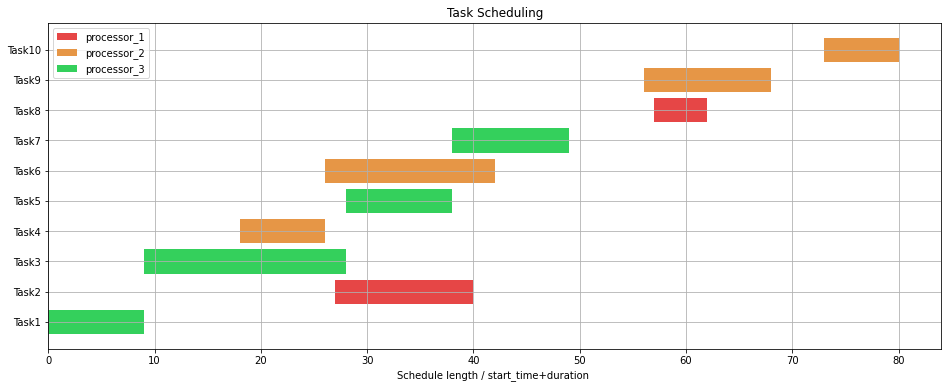

In [ ]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1, figsize=(16,6))
plt.barh(y=df.Task, left=df.Start, width=df.Duration,color = df.color, label=df.Resource)
ax.set_xlabel('Schedule length / start_time+duration ')
ax.set_title('Task Scheduling')
c_dict = {'processor_1':'#E64646', 'processor_2':'#E69646', 'processor_3':'#34D05C'}
legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
# legend_elements = [Patch(facecolor=df.color[i], label=i)  for i in list(df.color)]
plt.legend(handles= legend_elements)
# plt.legend(handles= df.color)
ax.grid(True)
# ax.annonate
plt.show()

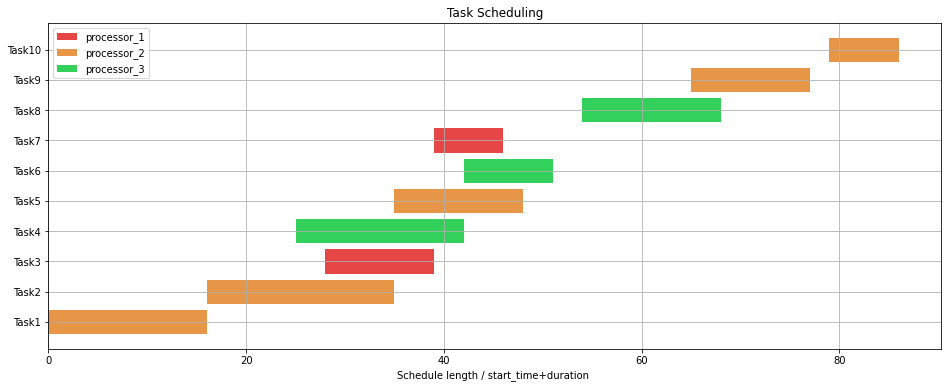

In [ ]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1, figsize=(16,6))
plt.barh(y=df1.Task, left=df1.Start, width=df1.Duration,color = df1.color, label=df1.Resource)
# legend_elements = [Patch(facecolor=df.color[i], label=i)  for i in list(df.color)]
# plt.legend(handles=list(df.color))
# plt.legend(handles=df.Resource)
c_dict = {'processor_1':'#E64646', 'processor_2':'#E69646', 'processor_3':'#34D05C'}
legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
# legend_elements = [Patch(facecolor=df.color[i], label=i)  for i in list(df.color)]
plt.legend(handles= legend_elements)
ax.set_xlabel('Schedule length / start_time+duration ')
ax.set_title('Task Scheduling')
ax.grid(True)
# ax.annonate
plt.show()

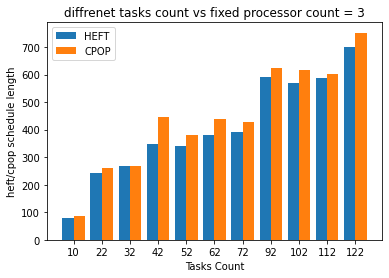

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

processor_count = 3

tasks_count = [10,22,32,42,52,62,72,92,102,112,122]
heft_schedule_length = [80,244,269,348,340,380,390,592,570,588,701]
cpop_schedule_length = [86,260,269,445,381,439,429,625,618,602,752]
X = ['Group A','Group B','Group C','Group D']
Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(tasks_count))

  
plt.bar(X_axis - 0.2, heft_schedule_length, 0.4, label = 'HEFT')
plt.bar(X_axis + 0.2, cpop_schedule_length, 0.4, label = 'CPOP')
  
plt.xticks(X_axis, tasks_count)
plt.xlabel("Tasks Count")  # add X-axis label
plt.ylabel("heft/cpop schedule length")  # add Y-axis label
plt.title("diffrenet tasks count vs fixed processor count = 3")  # add title
plt.legend()
plt.show()

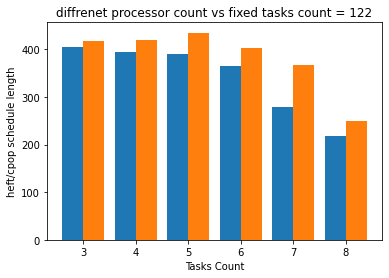

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

task_count = 122

processor_count = [3, 4, 5, 6, 7, 8]
heft_schedule_length = [404,395,390,365,279,218]
cpop_schedule_length = [417,420,435,402,367,249]


  
X_axis = np.arange(len(processor_count))

  
plt.bar(X_axis - 0.2, heft_schedule_length, 0.4, label = 'HEFT')
plt.bar(X_axis + 0.2, cpop_schedule_length, 0.4, label = 'CPOP')
  
plt.xticks(X_axis, processor_count)
plt.xlabel("Tasks Count")  # add X-axis label
plt.ylabel("heft/cpop schedule length")  # add Y-axis label
plt.title("diffrenet processor count vs fixed tasks count = 122")  # add title
plt.show()
